# Loading Model 

In [3]:
import os
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, Lambda
from tensorflow.keras.models import load_model


2021-11-26 18:18:05.997853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-26 18:18:05.997990: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
con_win_size = 9
num_strings = 6
num_classes = 21
input_shape = (192, con_win_size, 1)

def softmax_by_string(t):
    sh = K.shape(t)
    string_sm = []
    for i in range(num_strings):
        string_sm.append(K.expand_dims(K.softmax(t[:, i, :]), axis=1))
    return K.concatenate(string_sm, axis=1)

def build_model():

    model = Sequential()
    model.add(
        Conv2D(32,
               kernel_size=(3, 3),
               activation="relu",
               input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes * num_strings))  # no activation
    model.add(Reshape((num_strings, num_classes)))
    model.add(Activation(softmax_by_string))

#     model.compile(loss=self.catcross_by_string,
#                   optimizer=Adadelta(),
#                   metrics=[self.avg_acc])

    return model
model = build_model()

2021-11-26 18:18:19.913350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-26 18:18:19.913471: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-26 18:18:19.914244: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-GP5BU3LN): /proc/driver/nvidia/version does not exist
2021-11-26 18:18:19.915420: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 7, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 188, 5, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 186, 3, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 93, 1, 64)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 93, 1, 64)         0         
                                                                 
 flatten (Flatten)           (None, 5952)              0         
                                                        

# Load model weights 

In [6]:
os.chdir('../h5-model')
!ls

full_val0_75acc_weights.h5


In [7]:
model.load_weights('full_val0_75acc_weights.h5')

In [8]:
model

In [9]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())
print(weights)
print(len(weights[0]))

[[array([[[[-1.14527084e-01, -7.00837746e-02,  1.64513141e-02,
          -8.46667960e-02,  7.80746713e-02, -6.10514767e-02,
           1.10172659e-01, -1.30868405e-01,  1.17944069e-01,
           8.05187821e-02,  1.33489624e-01, -6.60827989e-03,
          -7.73175359e-02,  3.72690037e-02,  1.03387728e-01,
           8.85068849e-02, -5.47240674e-02, -9.36797783e-02,
           2.81246901e-02,  3.64853963e-02,  1.42038763e-01,
          -3.35541889e-02, -2.07621288e-02,  3.52249779e-02,
          -1.24825507e-01, -1.00334905e-01,  6.65799752e-02,
          -1.16388358e-01, -3.19974236e-02, -1.70573920e-01,
          -7.60619119e-02,  1.46001697e-01]],

        [[-4.05685678e-02,  1.66681096e-01,  1.29631609e-01,
          -2.65946500e-02,  5.08399941e-02, -1.38498351e-01,
          -6.97663724e-02, -1.22033164e-01,  1.14255841e-03,
           1.18322901e-01, -1.16930827e-01,  1.51325539e-01,
          -5.27841933e-02,  6.96947202e-02, -1.35874555e-01,
           1.45532504e-01,  1.409107

# preprocess experimentmono.wav 


In [10]:
import os
import numpy as np
import jams
from scipy.io import wavfile
import sys
import librosa
from tensorflow.keras.utils import to_categorical


class TabDataReprGen:
    def __init__(self, mode="c"):
        # file path to the GuitarSet dataset
        path = "data/GuitarSet/"
        self.path_audio = path + "audio/audio_mic/"
        self.path_anno = path + "annotation/"

        # labeling parameters
        self.string_midi_pitches = [40, 45, 50, 55, 59, 64]
        self.highest_fret = 19
        self.num_classes = self.highest_fret + 2  # for open/closed

        # prepresentation and its labels storage
        self.output = {}

        # preprocessing modes
        #
        # c = cqt
        # m = melspec
        # cm = cqt + melspec
        # s = stft
        #
        self.preproc_mode = mode    # Preprocessing mode for the wav file data
        self.downsample = True      # Select to lower sample rate of data
        self.normalize = True       # Select to normalize data
        self.sr_downs = 22050       # Lowered sample rate

        # CQT parameters
        self.cqt_n_bins = 192           # Number of bins for the constant-Q transform "c"
        self.cqt_bins_per_octave = 24   # Number of bins per octave

        # STFT parameters
        self.n_fft = 2048       # Length of the FFT window
        self.hop_length = 512   # Number of samples between successive frames

        # save file path
        self.save_path = "data/spec_repr/" + self.preproc_mode + "/"

    def load_rep_and_labels_from_raw_file(self, filename):
        """
        Loads wav and jams files, reads wav file and creates sample rate [int]
        and data [np.array].
        Constructs, cleans, and categorizes labels and stores them in output dict
        Returns the number of frames
        """
        file_audio = filename
        #file_audio = self.path_audio + filename + "_mic.wav"    # wav file
        #file_anno = self.path_anno + filename + ".jams"         # jams file
        #jam = jams.load(file_anno)                              # loads jams file
        self.sr_original, data = wavfile.read(file_audio)       # creates sample rate [int] and data from wav file
        self.sr_curr = self.sr_original

        # preprocess audio, store in output dict
        self.output["repr"] = np.swapaxes(self.preprocess_audio(data), 0, 1)

        # construct labels
        frame_indices = range(len(self.output["repr"]))  # Counts the frames
        times = librosa.frames_to_time( # Converts frame counts to time (seconds)
            frame_indices,
            sr=self.sr_curr,            # Sample rate
            hop_length=self.hop_length  # Number of samples between successive frames
            )
        return data


    
    
    def correct_numbering(self, n):
        """
        Adds +1 to correct the string number
        """
        n += 1
        if n < 0 or n > self.highest_fret:
            n = 0
        return n

    def categorical(self, label):
        """
        Categorizes the label in the number of classes defined
        (highest_fret (19) + 2  # for open/closed)
        """
        return to_categorical(label, self.num_classes)

    def clean_label(self, label):
        """
        Takes the label, corrects the string numbering and categorizes the label
        using to_categorical.
        Returns categorized and clean label
        """
        label = [self.correct_numbering(n) for n in label]
        return self.categorical(label)

    def clean_labels(self, labels):
        """
        Returns an array of all the cleaned labels with the correct string numbering
        and categorized according to the number of classes defined
        """
        return np.array([self.clean_label(label) for label in labels])

    def preprocess_audio(self, data):
        """
        Preprocesses data depending on mode selected using librosa.
        It converts data to float, then it normalizes it and resamples it
        to a lower sample rate. Then, preprocesses it and returns the processed data
            Args:
                data ([np.array]): [data created by wavfile.read]
            Returns:
                [np.ndarrray[shape=(n_bins, t)]]: [preprocessed data array]
        """
        data = data.astype(float)
        if self.normalize:
            data = librosa.util.normalize(data)
        if self.downsample:
            data = librosa.resample(data, self.sr_original, self.sr_downs)
            self.sr_curr = self.sr_downs
        if self.preproc_mode == "c":
            data = np.abs(
                librosa.cqt(data,     # Computes the constant-Q transform of an audio signal
                            hop_length=self.hop_length,
                            sr=self.sr_curr,        # data sample rate
                            n_bins=self.cqt_n_bins,
                            bins_per_octave=self.cqt_bins_per_octave))
        else:
            print("invalid representation mode.")

        return data

    def save_data(self, filename):
        """
        Saves the generated data output dictionary into an npz file
        """
        np.savez(filename, **self.output)

    def get_nth_filename(self, n):
        """
        Sorts the jams files in the directory, looks for the nth one,
        removes the .jams extension and returns only the filename
            Returns:
                [str]: [filename]
        """
        filenames = np.sort(np.array(os.listdir(self.path_anno)))
        filenames = list(filter(lambda x: x[-5:] == ".jams", filenames))
        print(filenames[n])
        return filenames[n][:-5]

    def load_and_save_repr_nth_file(self, n):
        """
        Gets the filename, preprocesses it, and gets the number of frames.
        Saves the file as an npz
        """

        filename = self.get_nth_filename(n)     # Gets only filename with no .jams extension
        print(filename)
        num_frames = self.load_rep_and_labels_from_raw_file(filename)
        print("done: " + filename + ", " + str(num_frames) + " frames")
        save_path = self.save_path
        if not os.path.exists(save_path):               # Creates saving path if it does not exist
            os.makedirs(save_path)
        self.save_data(save_path + filename + ".npz")   # Saves generated output dictionary in an npz file

In [21]:
import pandas as pd
import numpy as np
filenames = '../raw_data/experimentmono.wav'
genrep = TabDataReprGen()
data = genrep.load_rep_and_labels_from_raw_file(filenames)
process = np.swapaxes(genrep.preprocess_audio(data),0,1)

process.shape

/tmp/ipykernel_9453/1941861401.py:59: WavFileWarning: Chunk (non-data) not understood, skipping it.
  self.sr_original, data = wavfile.read(file_audio)       # creates sample rate [int] and data from wav file


(711, 192)

In [18]:
halfwin = con_win_size // 2

In [22]:
full_x = np.pad(process, [(halfwin, halfwin), # full x is the entire song padded with halfwin*2 frames
                                             (0, 0)],mode='constant')
full_x.shape

(719, 192)

In [29]:
full_x.shape[0]

719

In [42]:
x_new = np.empty((full_x.shape[0],192,9,1))
for frame_idx in range(0,full_x.shape[0]): # for all frames in the experiment
    sample_x = full_x[frame_idx:frame_idx + con_win_size]
    np.append(x_new,np.expand_dims(np.swapaxes(sample_x, 0, 1), -1))


In [43]:
x_new.shape

(719, 192, 9, 1)

In [44]:
y_pred = model.predict(x_new)

In [47]:
y_pred.shape

(719, 6, 21)

In [57]:
pd.DataFrame(y_pred[467])

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.992294,0.001195,0.000415,0.001278,0.002004,0.000884,0.000505,0.000557,0.000367,0.000125,...,0.000027,0.000057,0.000030,0.000022,0.000017,0.000020,0.000032,0.000029,0.000026,0.000038
1,0.986600,0.000593,0.000814,0.001053,0.001766,0.002129,0.001480,0.003172,0.000926,0.000452,...,0.000238,0.000103,0.000058,0.000032,0.000046,0.000013,0.000013,0.000021,0.000016,0.000009
2,0.970662,0.000918,0.000366,0.001193,0.002636,0.001788,0.002237,0.007382,0.001675,0.007143,...,0.001730,0.000576,0.000167,0.000166,0.000059,0.000037,0.000024,0.000018,0.000052,0.000030
3,0.957465,0.001125,0.001582,0.002689,0.001605,0.003633,0.002892,0.009490,0.005513,0.003275,...,0.002956,0.001334,0.000685,0.000612,0.000070,0.000096,0.000032,0.000098,0.000049,0.000054
4,0.955603,0.001501,0.001680,0.002755,0.001441,0.003293,0.004368,0.008746,0.003153,0.006144,...,0.002650,0.001481,0.001079,0.001001,0.000117,0.000308,0.000149,0.000069,0.000037,0.000052
5,0.981500,0.001551,0.000632,0.001727,0.001702,0.001364,0.000966,0.002485,0.001595,0.001890,...,0.001696,0.000601,0.000693,0.000489,0.000079,0.000018,0.000082,0.000036,0.000026,0.000034


In [52]:
import matplotlib.pyplot as plt


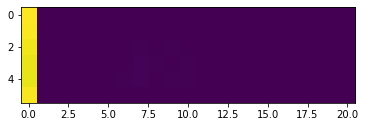

In [60]:
for frame in range(0,719):
    plt.imshow(y_pred[frame])